# Surplus Study

**The purpose of this study is to measure the surplus for historic COW trades for a desired token pair.** 


**Definitions:**
X = reserves of token1
Y = reserves of token2
dx = trade quantity of token1 for a given trade
dy = trade quantity of token2 for a given trade 

**Surplus Calculations:** 

Surplus is defined by (Pfeedlot - Pmarket) * quantity 


- Surplus_price: defined as the surplus in price terms defined as follows:
    - Pfeedlot = X / Y 
    - Pmarket = dx / dy
    - surplus_ price = Pfeedlot - Pmarket 
      
- Surplus_usdt: Surplus volume in USDT terms defined as follows: 
    - surplus_price * dy  

Note: Since P is defined generally here as X / Y (or dx / dy for a swap) then the quantity to multiply to obtain surplus is dy. 




**Methodology:** 
- Assume a Feedlot AMM with CPMM preferences that only trades COW orders. Given by XY = K  
    where:  
        X = reserves of token1   
        Y = reserves of token2  
        K = X * Y  
        
- Feedlot AMM trades at the COW settelement price (which is the solver price) if the trade offers satisfies the preferences (k_new > k_current) and retains any difference (surplus) 
          
- Given a dataset that represents the list of all trades that happened on COW Swap with value over USD 100 with first trade at timestamp $t_0$. 
- Model Inputs: 
    - `token1`: Token1 of token pair to be studied 
    - `Token2`: Token2 of token pair to be studied 
    - `token1_starting_reserves`: Starting reserves of the feedlot AMM pool. 
    - `fee_rate`: Fee rate charged to the trade 
  
- Initialize a feedlot AMM for token1 and token2, at $t_0$ with the price of the first trade at t0 of the COW dataset of token1 and token2, using the starting reserves given by the input (calculating token1_starting_reserves * price at $t_0$) 

- Loop through all trades and check at each trade if $P_Feedlot$ < $P_Cow_execution$. (This is also given by $k_new$ > k_current). If the price of feedlot was favourable then trade is executed on Feedlot AMM and new reserves are updated. 

### 1. Loading COW Dataset 

Copy the dataset file into the folder that contains this notebook. 

In [256]:
from datastreams.datastream import Streamer

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

# These commands enlarge the column size of the dataframe so things like 0x... are not truncated
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [257]:
# instantiate Streamer class. Note that we need two separate streamer classes, otherwise the queries will be overwritten. 
cow_ds = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')

In [258]:
# DEFINE TIMESTAMP HERE. Minimum Timstamp is used for replication quality assurance purposes. Timestamp date: 
timestamp =  1646464506

# we set a fixed query size number. The Cow settlements and Uniswap swaps query are multiples larger than this initial query size.
query_size = 250000

#Filter size - We filter trades out that are smaller than $1000 USD size
filter_usd = 100

In [273]:
# query COW schema: trades
trades_fp = cow_ds.queryDict.get('trades')

# trades query path that gets token a -> token b trades. Query on query_size. 
trades_qp = trades_fp(
    first=query_size,
    orderBy='timestamp',
    orderDirection='desc',
    where = {
    'timestamp_gt': timestamp
    }
)

# run query
trades_df = cow_ds.runQuery(trades_qp)

FIELD - trades


KeyboardInterrupt: 

In [274]:
print(f'query returned {len(trades_df)} rows')

query returned 250000 rows


In [275]:
trades_df.head(5)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_order_id,trades_buyAmountEth,trades_sellAmountEth,trades_buyAmountUsd,trades_sellAmountUsd,endpoint
0,0x02b495e457bafb9e4997d0420b92c9fd06af6a0241aaf4e37816a00e7959b588b33d843bb956e03720dd78b1c3deefc502a4bbe664044844|0x878b30f34fea99196052ebb2a3ab9e3230c73984fe508f658f92114a1f1df2bb|87,1678000487,20983805760,8207755,0x878b30f34fea99196052ebb2a3ab9e3230c73984fe508f658f92114a1f1df2bb,0x878b30f34fea99196052ebb2a3ab9e3230c73984fe508f658f92114a1f1df2bb,1829794398516,1200000000,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0x02b495e457bafb9e4997d0420b92c9fd06af6a0241aaf4e37816a00e7959b588b33d843bb956e03720dd78b1c3deefc502a4bbe664044844,0.7557,0.7626,1189.2666,1200.0000,cow
1,0x4b3df1687abca8841e66406b657ca68281a3a93edccce70af4fe7caeff4bf3a59faa6a2cd5385fc277498254e535eb617ffd0c63640455cb|0x775e9c915b2993dc163483d45e6c0ba734115033aa667f00bc19d7c386781879|133,1677999803,24042526695,26241180,0x775e9c915b2993dc163483d45e6c0ba734115033aa667f00bc19d7c386781879,0x775e9c915b2993dc163483d45e6c0ba734115033aa667f00bc19d7c386781879,181472371867880187826,3003594354,0xdac17f958d2ee523a2206206994597c13d831ec7,0x616e8bfa43f920657b3497dbf40d6b1a02d4608d,0x4b3df1687abca8841e66406b657ca68281a3a93edccce70af4fe7caeff4bf3a59faa6a2cd5385fc277498254e535eb617ffd0c63640455cb,0.0000,1.9086,0.0000,3003.5944,cow
2,0xff0681a3980d77ed4520ab76c62c58c3ca4f9939fa66ecb8420ac6d9b2af384254f5734e213add7fac237fc16a235f4bb272bca064044546|0x29e8a5d81542fe189d7cb3c04b470a1d5e980567d53d6cc1c451bf33e318dfca|25,1677999743,24110968497,5484459848793709568,0x29e8a5d81542fe189d7cb3c04b470a1d5e980567d53d6cc1c451bf33e318dfca,0x29e8a5d81542fe189d7cb3c04b470a1d5e980567d53d6cc1c451bf33e318dfca,25255056949860802,40000000000000000000,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xff0681a3980d77ed4520ab76c62c58c3ca4f9939fa66ecb8420ac6d9b2af384254f5734e213add7fac237fc16a235f4bb272bca064044546,0.0253,0.0290,39.7434,45.6947,cow
3,0x54afc8454e6d83babacab5b4243227a21975bd514ded6f131e7eb5d6b2278c5ce125ea8fe5668ebd015c1a73b3ca359fb32cd20d64043fed|0x8c2ba0c47a40c4447efaebc3695ce0ab73d82298e007803bb6e9d6835be09cd9|178,1677999215,19299798870,0,0x8c2ba0c47a40c4447efaebc3695ce0ab73d82298e007803bb6e9d6835be09cd9,0x8c2ba0c47a40c4447efaebc3695ce0ab73d82298e007803bb6e9d6835be09cd9,86971133598030460928,179381613972055168,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc0c293ce456ff0ed870add98a0828dd4d2903dbf,0x54afc8454e6d83babacab5b4243227a21975bd514ded6f131e7eb5d6b2278c5ce125ea8fe5668ebd015c1a73b3ca359fb32cd20d64043fed,0.1799,0.1794,283.1655,282.2893,cow
4,0x030d7c9ec207db1e436cb223ed7900681b8b7bb388c9f1a1201f210b9a49aab1b46296bfa66c72829d823042e9a25f2e5dd6eec0640453b4|0x8c2ba0c47a40c4447efaebc3695ce0ab73d82298e007803bb6e9d6835be09cd9|178,1677999215,19299798870,2028866401969539072,0x8c2ba0c47a40c4447efaebc3695ce0ab73d82298e007803bb6e9d6835be09cd9,0x8c2ba0c47a40c4447efaebc3695ce0ab73d82298e007803bb6e9d6835be09cd9,179381613972055159,89000000000000000000,0xc0c293ce456ff0ed870add98a0828dd4d2903dbf,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0x030d7c9ec207db1e436cb223ed7900681b8b7bb388c9f1a1201f210b9a49aab1b46296bfa66c72829d823042e9a25f2e5dd6eec0640453b4,0.1794,0.1841,282.2893,289.7712,cow


In [276]:
# Set query size large enough to retrieve all tokens in the graph
query_size_token = 10000000

token_fp = cow_ds.queryDict.get('tokens')

# add parameters to the settlements_qp.
token_qp = token_fp(
    first=query_size_token,
)

# run query
token_df = cow_ds.runQuery(token_qp)

FIELD - tokens


In [277]:
# Merge1 on sell token address.  x = sell token 

merged_df = pd.merge(trades_df, token_df, left_on='trades_sellToken_id', right_on='tokens_address')

In [278]:
# Merge2 on buy token address.  y = buy token 
merged_df2 = pd.merge(merged_df, token_df, left_on='trades_buyToken_id', right_on='tokens_address')

In [279]:
df = merged_df2.rename(columns={
    "tokens_symbol_x": "sell_token_symbol",
    "tokens_symbol_y":"buy_token_symbol",
    "tokens_decimals_x": "sell_token_decimal", 
    "tokens_decimals_y": "buy_token_decimal"})

In [280]:
df.head(5)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_order_id,trades_buyAmountEth,trades_sellAmountEth,trades_buyAmountUsd,trades_sellAmountUsd,endpoint_x,tokens_id_x,tokens_address_x,tokens_firstTradeTimestamp_x,tokens_name_x,sell_token_symbol,sell_token_decimal,tokens_totalVolume_x,tokens_priceEth_x,tokens_priceUsd_x,tokens_numberOfTrades_x,tokens_totalVolumeUsd_x,tokens_totalVolumeEth_x,endpoint_y,tokens_id_y,tokens_address_y,tokens_firstTradeTimestamp_y,tokens_name_y,buy_token_symbol,buy_token_decimal,tokens_totalVolume_y,tokens_priceEth_y,tokens_priceUsd_y,tokens_numberOfTrades_y,tokens_totalVolumeUsd_y,tokens_totalVolumeEth_y,endpoint
0,0x02b495e457bafb9e4997d0420b92c9fd06af6a0241aaf4e37816a00e7959b588b33d843bb956e03720dd78b1c3deefc502a4bbe664044844|0x878b30f34fea99196052ebb2a3ab9e3230c73984fe508f658f92114a1f1df2bb|87,1678000487,20983805760,8207755,0x878b30f34fea99196052ebb2a3ab9e3230c73984fe508f658f92114a1f1df2bb,0x878b30f34fea99196052ebb2a3ab9e3230c73984fe508f658f92114a1f1df2bb,1829794398516,1200000000,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0x02b495e457bafb9e4997d0420b92c9fd06af6a0241aaf4e37816a00e7959b588b33d843bb956e03720dd78b1c3deefc502a4bbe664044844,0.7557,0.7626,1189.2666,1200.0000,cow,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,1628188144,USD Coin,USDC,6,12270490063292735,0.0006,1.0000,209379,12270490063.2927,6483430.0960,cow,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,1628776245,HEX,HEX,8,266801703550912157,0.0000,0.0650,9309,136048968.0964,76599.4965,cow
1,0x9b4534c4f6fbbc303c2b9f2368d21534d4cd920c61b6f4d83a6a302f1004bfebaf109fa55c809ce50b25c552944c92975aed04c96403eeb6|0x6e8c957c2d5f8b6cb83b9c02220c695af6ca63a6d2f5282a2ee921a582e2b4ef|108,1677977567,19220865647,7338892,0x6e8c957c2d5f8b6cb83b9c02220c695af6ca63a6d2f5282a2ee921a582e2b4ef,0x6e8c957c2d5f8b6cb83b9c02220c695af6ca63a6d2f5282a2ee921a582e2b4ef,6870123050739,4513622261,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0x9b4534c4f6fbbc303c2b9f2368d21534d4cd920c61b6f4d83a6a302f1004bfebaf109fa55c809ce50b25c552944c92975aed04c96403eeb6,2.8734,2.8843,4496.5948,4513.6223,cow,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,1628188144,USD Coin,USDC,6,12270490063292735,0.0006,1.0000,209379,12270490063.2927,6483430.0960,cow,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,1628776245,HEX,HEX,8,266801703550912157,0.0000,0.0650,9309,136048968.0964,76599.4965,cow
2,0xf5dcf25a56511a2493ddcfd3bf6cf594494265fe88c8bd2184ec3edc32c6803ae946ada93cf368b0f33bb3ee170a7b8c337998426403c144|0x3f80906d1c0df3593d2383d8364a5e0b08268a9b39dd1d1114cd096ff190ff90|98,1677965915,31750397504,13500877,0x3f80906d1c0df3593d2383d8364a5e0b08268a9b39dd1d1114cd096ff190ff90,0x3f80906d1c0df3593d2383d8364a5e0b08268a9b39dd1d1114cd096ff190ff90,1541289644987,997502314,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0xf5dcf25a56511a2493ddcfd3bf6cf594494265fe88c8bd2184ec3edc32c6803ae946ada93cf368b0f33bb3ee170a7b8c337998426403c144,0.6324,0.6421,982.4739,997.5023,cow,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,1628188144,USD Coin,USDC,6,12270490063292735,0.0006,1.0000,209379,12270490063.2927,6483430.0960,cow,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,1628776245,HEX,HEX,8,266801703550912157,0.0000,0.0650,9309,136048968.0964,76599.4965,cow
3,0x4400f936824c4c966b25d712fc491d73cd0f8461974320329d3e8e9bd8e2b36cb119aa62031a225a7969fd6787cef7b5aa35dfef640c70c3|0xae131c6a3a3e5f8ab555855a1278eef2d38e58ab142183055343cec3c5cb4cf1|107,1677962315,34898867919,0,0xae131c6a3a3e5f8ab555855a1278eef2d38e58ab142183055343cec3c5cb4cf1,0xae131c6a3a3e5f8

In [281]:
df.dtypes

trades_id                        object
trades_timestamp                  int64
trades_gasPrice                   int64
trades_feeAmount                 object
trades_txHash                    object
trades_settlement_id             object
trades_buyAmount                 object
trades_sellAmount                object
trades_sellToken_id              object
trades_buyToken_id               object
trades_order_id                  object
trades_buyAmountEth             float64
trades_sellAmountEth            float64
trades_buyAmountUsd             float64
trades_sellAmountUsd            float64
endpoint_x                       object
tokens_id_x                      object
tokens_address_x                 object
tokens_firstTradeTimestamp_x      int64
tokens_name_x                    object
sell_token_symbol                object
sell_token_decimal                int64
tokens_totalVolume_x             object
tokens_priceEth_x               float64
tokens_priceUsd_x               float64


In [282]:
df = df[[
    'trades_id',                        
    'trades_timestamp',                  
    'trades_gasPrice',                   
    'trades_feeAmount',                 
    'trades_txHash',                    
    'trades_buyAmount',                 
    'trades_sellAmount',                
    'trades_sellToken_id',              
    'trades_buyToken_id',               
    'trades_buyAmountUsd',             
    'trades_sellAmountUsd',            
    'sell_token_symbol',                
    'sell_token_decimal',                
    'buy_token_symbol',                 
    'buy_token_decimal'                 
    
]]

In [283]:
df.head(3)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_buyAmountUsd,trades_sellAmountUsd,sell_token_symbol,sell_token_decimal,buy_token_symbol,buy_token_decimal
0,0x02b495e457bafb9e4997d0420b92c9fd06af6a0241aaf4e37816a00e7959b588b33d843bb956e03720dd78b1c3deefc502a4bbe664044844|0x878b30f34fea99196052ebb2a3ab9e3230c73984fe508f658f92114a1f1df2bb|87,1678000487,20983805760,8207755,0x878b30f34fea99196052ebb2a3ab9e3230c73984fe508f658f92114a1f1df2bb,1829794398516,1200000000,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,1189.2666,1200.0000,USDC,6,HEX,8
1,0x9b4534c4f6fbbc303c2b9f2368d21534d4cd920c61b6f4d83a6a302f1004bfebaf109fa55c809ce50b25c552944c92975aed04c96403eeb6|0x6e8c957c2d5f8b6cb83b9c02220c695af6ca63a6d2f5282a2ee921a582e2b4ef|108,1677977567,19220865647,7338892,0x6e8c957c2d5f8b6cb83b9c02220c695af6ca63a6d2f5282a2ee921a582e2b4ef,6870123050739,4513622261,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,4496.5948,4513.6223,USDC,6,HEX,8
2,0xf5dcf25a56511a2493ddcfd3bf6cf594494265fe88c8bd2184ec3edc32c6803ae946ada93cf368b0f33bb3ee170a7b8c337998426403c144|0x3f80906d1c0df3593d2383d8364a5e0b08268a9b39dd1d1114cd096ff190ff90|98,1677965915,31750397504,13500877,0x3f80906d1c0df3593d2383d8364a5e0b08268a9b39dd1d1114cd096ff190ff90,1541289644987,997502314,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,982.4739,997.5023,USDC,6,HEX,8


In [284]:
# calculate buy and sell amounts from the correct decimal 
df['buy_amount'] = df.apply(lambda x: x['trades_buyAmount'] / (10**x['buy_token_decimal']), axis=1)
df['sell_amount'] = df.apply(lambda x: x['trades_sellAmount'] / (10**x['sell_token_decimal']), axis=1)

In [285]:
# Add new empty columns needed for analysis & specify their data types 
df['cow_price'] = 0.0                  
df['pool_initial_price'] = 0.0  # price of the pool before accounting for trade impact. Perhaps change to compute actual trade price. 
df['surplus_usdt'] = 0.0            
df['surplus_price'] = 0.0          
df['surplus_percent'] = 0.0        
df['executed'] = False     
df['k']=0.0  #23
df['k_new']=0.0 #24

df['cow_price'] = df['cow_price'].astype(float)
df['pool__initial_price'] = df['pool_initial_price'].astype(float)
df['surplus_usdt'] = df['surplus_usdt'].astype(float)
df['surplus_price'] = df['surplus_price'].astype(float)
df['surplus_percent'] = df['surplus_percent'].astype(float)
df['executed'] = df['executed'].astype(bool)
df['k'] = df['k'].astype(float)
df['k_new'] =df['k_new'].astype(float) 

In [286]:
df.dtypes

trades_id                object
trades_timestamp          int64
trades_gasPrice           int64
trades_feeAmount         object
trades_txHash            object
trades_buyAmount         object
trades_sellAmount        object
trades_sellToken_id      object
trades_buyToken_id       object
trades_buyAmountUsd     float64
trades_sellAmountUsd    float64
sell_token_symbol        object
sell_token_decimal        int64
buy_token_symbol         object
buy_token_decimal         int64
buy_amount              float64
sell_amount             float64
cow_price               float64
pool_initial_price      float64
surplus_usdt            float64
surplus_price           float64
surplus_percent         float64
executed                   bool
k                       float64
k_new                   float64
pool__initial_price     float64
dtype: object

## 2. Define Surplus calculation function 

Detailed steps of the function: 

1. Filter the dataset for token1 and token2 trades only
2. Calculate price for each trade based on whether token1 was the buy or token2. Price defined as Token1/Token2. 
3. Use the price of the first trade to initialize the feedlot AMM pool with token1_starting_reserves
3. Loop through trades and check if k_new > k and if yes, execute trade by reflecting new reserves level 

Note about fees calculation. For the purpose of this study we wish to study the actual historic trades and use them as final quantities. This means the dx and dy values do not change. To incorporate fees the dy price is the dy/(1+s). This is because the (1+s) * dy should equal to the sell_amount hence. 

To fix: 
1. Fee calculation methodology 
2. Change starting reserves paradigm to tvl paradigm as its more relateabl 


Note about fees calculations: 


  

In [331]:
from datetime import datetime
 

def surplus_analysis(token1:str, token2:str, token1_starting_reserves:int, fee_rate:float):
    
    """
    Perform surplus analysis for specific trading pair given by token1 and token2. 

    This function filters the required tokens for the simulation, initializes a feedlot AMM (CPMM) with starting 
    price corresponding to first trade in the list and a given initial reserves, loops through trade by trade and 
    checks if Pfeedlot < Pmarket. If yes (k_new > k_current), it executes the trade in Feedlot using the standard 
    CPMM formula. 

    Parameters:
        token1 (str): The first token to perform the surplus analysis on.
        token2 (str): The second token to perform the surplus analysis on.
        starting_reserves (int): The starting reserves of token1. 
        fee_rate (float): The fee rate for the transactions.

    Returns:
        trades_executed_percentage : Percentage of trades executed on Feedlot AMM that met the condition Pfeedlot < Pmarket
        executed_volume_percentage : volume of executed trades as percentage of total volume of swaps for token1 and token2
        total_surplus: Sum of surplus in USD terms 
    
    """
    
    
    # Filter the required tokens for the simulation 
   
    dfs = df[((df.buy_token_symbol == token1) & (df.sell_token_symbol == token2)) | ((df.sell_token_symbol == token1) & (df.buy_token_symbol == token2))]
    #dfs.to_csv('debug1.csv', index=False)
    dfs.sort_values(by='trades_timestamp', ascending=False, inplace=True)
    dfs = dfs[dfs['trades_sellAmountUsd'] > 250]
    dfs = dfs.reset_index(drop=True)
    
    print('dfs', len(dfs), 'trades in sample')
    
    #dfs.to_csv('debug2.csv', index=False)

    
    # Calculate price column. Only important for analysis is first price to initialize pool with it. 
    # Check if its a buy or a sell and calculate accordingly. 
    for i in range(len(dfs)):
        if dfs.iloc[i,11] == token1:
            dfs.iloc[i,17] = dfs.iloc[i,16] / dfs.iloc[i,15]  

        if dfs.iloc[i,11] == token2:
            dfs.iloc[i,17] = dfs.iloc[i,15] / dfs.iloc[i,16]     
    dfs = dfs[dfs['cow_price'] != 0]
    
    print('price column added')
    
    #dfs.to_csv('debug3.csv', index=False)

    
    
    # initialize AMM pool 
    s = fee_rate 
    initialization_price = dfs.iloc[-1,17]  
    token2_starting_reserves = token1_starting_reserves / initialization_price
    x = token1_starting_reserves 
    y = token2_starting_reserves 
    k = x * y 
    k_new = k 
    
    print('****** Feedlot AMM Initial State **********')
    print('''AMM Initialized with the following parameters:
    initilization price = {}
    x= {}
    y= {}
    k= {}
    s= {}'''.format(initialization_price, token1_starting_reserves, token2_starting_reserves, k, s))


    # Iterating through trades and checking if the trade would have been executed through Feedlot AMM
    # The condition is k_new > k  
    # Variables to monitor (trades: total trades executed, fees: total fees collected, volume : total volume executed) 

    trades  = 0 
    fees_collected = 0 
    volume = 0 
    
    for i in range(len(dfs)):
        
        dfs.iloc[i,18] = x / y 
        dfs.iloc[i,23] = k

        # if token_1 is the "buy token"
        if dfs.iloc[i,13] == token1:
            dx = dfs.iloc[i,15]
            dy = dfs.iloc[i,16]
            k_new = (x - dx) * (y + (dy/(1+s))) 
            dfs.iloc[i,24] = k_new
            
            if k_new > k:
                surplus_price = abs((x / y)- dfs.iloc[i,17])
                dfs.iloc[i,19] =  surplus_price * dy  # surplus in dollar volume surplus  
                dfs.iloc[i,20] = surplus_price
                dfs.iloc[i,21] = surplus_price / dfs.iloc[i,6] * 100 # percentage
                dfs.iloc[i,22] = 1 # trade executed signal 
                volume = volume + dfs.iloc[i,10]
                fees_collected = fees_collected + (s * dfs.iloc[i,10]) 
                trades = trades + 1 
                k = k_new 
                x = x - dx
                y = y + dy/(1+s)

        # if token_2 is the "buy token"
        elif dfs.iloc[i,13] == token2:
            dx = dfs.iloc[i,16] 
            dy = dfs.iloc[i,15]
            k_new = (x + (dx/(1+s))) * (y - dy) 
            dfs.iloc[i,24] = k_new

            if k_new > k: 
                surplus_price = abs((x / y)- dfs.iloc[i,17])
                dfs.iloc[i,19] =  surplus_price * dy  # surplus in dollar volume terms 
                dfs.iloc[i,20] = surplus_price
                dfs.iloc[i,21] = surplus_price / dfs.iloc[i,6] * 100 # percentage
                dfs.iloc[i,22] = 1 # trade executed signal 
                volume = volume + dfs.iloc[i,10]
                fees_collected = fees_collected + (s * dfs.iloc[i,10]) 
                trades = trades + 1 
                k = k_new 
                x = x + dx/(1+s)
                y = y - dy

    #dfs.to_csv('debug4.csv', index=False)

    # Analysis results 
    
    total_trades = len(dfs)
    
    # use the sell amount USD provided in subgraph as an estimate for total trade volume
    total_volume = dfs['trades_sellAmountUsd'].sum()
    total_surplus = dfs['surplus_usdt'].sum() 

    trades_executed_percentage = trades / total_trades * 100 
    executed_volume_percentage = volume / total_volume * 100 
    total_surplus_percentage = total_surplus/ total_volume *100
    
    
    # calculate return metrics 
    starting_date = datetime.utcfromtimestamp(dfs.iloc[0,1]).strftime('%Y-%m-%d')
    ending_date = datetime.utcfromtimestamp(dfs.iloc[-1,1]).strftime('%Y-%m-%d')
    # divide by 3600 because timestamp is in unix10 format which is in seconds. 
    days = (datetime.utcfromtimestamp(dfs.iloc[0,1]) - datetime.utcfromtimestamp(dfs.iloc[-1,1]))
    
    ending_reserves_1 = x 
    ending_reserves_2 = y 
    
    print('******** Results Data **********************')
    print('  Inputs:')
    print('token1', token1)
    print('token2', token2)
    print('initial Reserves', token1_starting_reserves)
    print('fee rate')
    print('  dataset timeframe:')
    print('starting date', datetime.utcfromtimestamp(dfs.iloc[0,1]).strftime('%Y-%m-%d'))
    print('ending date', datetime.utcfromtimestamp(dfs.iloc[-1,1]).strftime('%Y-%m-%d'))
    print('days', days)
    print('  Trades:')
    print('trades executed = ', trades)
    print('total_trades= ', total_trades)
    print('percentage of trades executed = ', trades_executed_percentage, '%') 
    print('  Volume:')
    print('total usd volume traded on feedlot= ', volume)
    print('total USD volume traded on COW', total_volume)
    print('volume percentage = ', volume / total_volume *100 , '%')
    print('  Surplus:')
    print('total surplus', total_surplus)
    print('surplus percentage of volume', total_surplus_percentage, '%')
    print('  LP metrics:')
    print('fees collected', fees_collected)  
    print('ending reserves token1', x)
    print('ending reserves token2', y)
    
    
    return trades_executed_percentage, executed_volume_percentage, total_surplus
                


## 3. USDC-WETH – comparison with real UNIv2 returns 

**Methodology**




#### 3.1 Get UNI V2 returns 

In [349]:
len(df)

250000

In [350]:
tokena = 'USDC'
tokenb = 'WETH'

In [351]:
weth_usdc_df = df[((df.buy_token_symbol == tokena) & (df.sell_token_symbol == tokenb)) | ((df.sell_token_symbol == tokena) & (df.buy_token_symbol == tokenb))]

In [361]:
weth_usdc_df = weth_usdc_df[weth_usdc_df['trades_sellAmountUsd'] > 250]
weth_usdc_df.sort_values(by='trades_timestamp', ascending=False, inplace=True)

In [362]:
len(weth_usdc_df)

13206

In [363]:
weth_usdc_df.iloc[0,1]

1677998135

In [366]:
weth_usdc_df.iloc[0,4]

'0x3f860c507adbf6d494b7551be83003c352679d328221fb3905111809051a4807'

In [ ]:
# Block Number last = 16760457
# https://etherscan.io/tx/0x3f860c507adbf6d494b7551be83003c352679d328221fb3905111809051a4807

In [364]:
weth_usdc_df.iloc[-1,1]

1652517778

In [367]:
weth_usdc_df.iloc[-1,4]

'0xdadea98cabf27a678d8b216b9d7904833f7fd47d7055e8e334ff83237614be2c'

In [ ]:
# Block Number first = 14772623
#https://etherscan.io/tx/0xdadea98cabf27a678d8b216b9d7904833f7fd47d7055e8e334ff83237614be2c

In [368]:
days = (datetime.utcfromtimestamp(weth_usdc_df.iloc[0,1]) - datetime.utcfromtimestamp(weth_usdc_df.iloc[-1,1]))
days

datetime.timedelta(days=294, seconds=78757)

In [ ]:
# Univ2 data at last trade:
# UNIV2 USDC_WETH Token supply @ 16760457 = 0.507018133622313572

# UNIV2 USDC Reserves = 42,913,124.870583 
# UNIV2 WETH reserves = 27,368.288045175179245375 


In [ ]:
# Univ2 data at first trade
# Block number = 15178494

# UNIV2 USDC_WETH Token supply @ 15178494 = 0.765511067122866243


# UNIV2 USDC Reserves = 60,651,879.922242 USDC
# UNIV2 WETH reserves = 39,439.883043133571417717  WETH

In [ ]:
# Simple TVL assuming 1.00 USDC = 1.00 USD

In [369]:
LP_token_value_end = (42913124.870583 *2) / 0.507018133622313572
LP_token_value_end

169276489.43834308

In [370]:
LP_token_value_start = (60651879.922242*2) / 0.765511067122866243
LP_token_value_start

158461144.52714303

In [371]:
r = LP_token_value_end/LP_token_value_start
r

1.0682523462989848

In [379]:
annual_return = 365 / 295 * (r-1) + 1
annual_return

1.0844478183021338

In [ ]:
# 8.44 % annual returns. This includes all fees and capital gains. 

In [ ]:
# get total volume traded in that pool 

In [380]:
uni_ds = Streamer('https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2')

In [387]:
# query COW schema: trades
uni_pool_fp = uni_ds.queryDict.get('pairDayDatas')

# trades query path that gets token a -> token b trades. Query on query_size. 
uni_pool_qp = uni_pool_fp(
    first=1000,
    orderBy='date',
    orderDirection='desc',
    where = {
    'date_gt': 1652517778,
    'pairAddress': "0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc"
    }
)

# run query
uni_pool_df = uni_ds.runQuery(uni_pool_qp)

FIELD - pairDayDatas


In [389]:
len(uni_pool_df)

295

In [390]:
uni_pool_df.dtypes

pairDayDatas_id                    object
pairDayDatas_date                   int64
pairDayDatas_pairAddress           object
pairDayDatas_token0_id             object
pairDayDatas_token1_id             object
pairDayDatas_reserve0             float64
pairDayDatas_reserve1             float64
pairDayDatas_totalSupply          float64
pairDayDatas_reserveUSD           float64
pairDayDatas_dailyVolumeToken0    float64
pairDayDatas_dailyVolumeToken1    float64
pairDayDatas_dailyVolumeUSD       float64
pairDayDatas_dailyTxns              int64
endpoint                           object
dtype: object

In [392]:
uni_pool_df

,pairDayDatas_id,pairDayDatas_date,pairDayDatas_pairAddress,pairDayDatas_token0_id,pairDayDatas_token1_id,pairDayDatas_reserve0,pairDayDatas_reserve1,pairDayDatas_totalSupply,pairDayDatas_reserveUSD,pairDayDatas_dailyVolumeToken0,pairDayDatas_dailyVolumeToken1,pairDayDatas_dailyVolumeUSD,pairDayDatas_dailyTxns,endpoint
0,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19421,1677974400,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,42960064.3484,27339.3376,0.5070,85924004.2027,1887769.2463,1201.9405,1887745.0536,1150,uniswap-v2
1,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19420,1677888000,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,42848870.9778,27356.1277,0.5066,85642266.6284,3217075.9505,2052.9171,3216985.4161,2890,uniswap-v2
2,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19419,1677801600,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,42894965.9885,27378.1445,0.5071,85864910.7315,6940617.1524,4413.2675,6942532.7364,3463,uniswap-v2
3,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19418,1677715200,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,45441763.8093,27565.2006,0.5238,90919180.0970,5022100.9683,3056.7824,5022999.1047,3159,uniswap-v2
4,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19417,1677628800,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,45609855.1069,27454.4789,0.5238,91217590.5846,5477149.5682,3329.2116,5475843.8147,3329,uniswap-v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19131,1652918400,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,81918381.7705,40544.6282,0.9350,163834663.2836,21353799.2317,10863.8632,21361310.3498,2759,uniswap-v2
291,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19130,1652832000,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,96524100.6640,50453.8672,1.1326,193141466.0761,19324630.6047,9726.3907,19339643.8626,2605,uniswap-v2
292,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19129,1652745600,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,100949544.8969,48213.7648,1.1326,201947888.3260,19495546.0959,9452.2256,19500977.6551,2587,uniswap-v2
293,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19128,1652659200,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,99145266.3386,49044.8554,1.1324,198410547.3519,28408679.7338,14031.9308,28425399.3490,2531,uniswap-v2


In [395]:
# Total volume of USDC 
total_uni_volume = uni_pool_df['pairDayDatas_dailyVolumeToken0'].sum()
total_uni_volume

3386282403.671873

#### 3.2 Get Simulation Feedlot returns

In [412]:
# run simulation with starting reserves = 60,651,879.922242 as per the UNIv2 pool 

surplus_analysis('USDC', 'WETH', 60651879.922242 , 0.003)

/tmp/ipykernel_6591/2927052887.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=True, inplace=True)


dfs 13206 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1572.69321081794
    x= 60651879.922242
    y= 38565.61439004219
    k= 2339077013112.327
    s= 0.003
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 60651879.922242
fee rate
  dataset timeframe:
starting date 2022-05-14
ending date 2023-03-05
days -295 days, 2:07:23
  Trades:
trades executed =  5447
total_trades=  13206
percentage of trades executed =  41.246403150083296 %
  Volume:
total usd volume traded on feedlot=  239556040.05803722
total USD volume traded on COW 1103024215.0397763
volume percentage =  21.71811251209916 %
  Surplus:
total surplus 10067092.324418273
surplus percentage of volume 0.9126809898779278 %
  LP metrics:
fees collected 718668.1201741144
ending reserves token1 64288486.09172879
ending reserves token2 41226.708602548075


(41.246403150083296, 21.71811251209916, 10067092.324418273)

In [414]:
# ending value + the fees 
ending_value = 64288486.09172879*2 + 718668.1201741144
ending_value

129295640.3036317

In [415]:
starting_value = 60651879.922242 * 2 
value2

112625702.60709316

In [417]:
ret = ending_value / starting_value 
ret

1.0658832048519649

In [418]:
annual = ((ret -1) * 365/295 )+1
annual

1.0815165076981939

What this result shows is that given the same reserves, but different order flows, LP at UNIv2 in same period would have returned more. 

COW returns = 8.11% 
UNIv2 returns = 8.44% 

However it is worth noting that COW processed 1,103,024,215.0397763 USDC volume 
in the same period, UNIv2 processed 3,386,282,403.671873 USDC volume. 


normalizing the result by 1bn usd volume we receive:

COW returns per 1bn USD volume: 7.215 mln in returns 
UNI returns per 1bn USD volumw: 3.194 mln in returns 


Looking at the percentage return normalized: 

COW non-annualized % returns per 1bn USD = 6.59 / 1.103024 = 5.974% 
UNIv2 non-annualized % returns per 1bn USD = 6.83 / 3.386282 = 2.017% 

In [397]:
feedlot_normalized = (total_value - starting_value) / 1.103024215  
feedlot_normalized 

7215222.301464608

In [398]:
univ2_normalized = (LP_token_value_end - LP_token_value_start) / 3.386282403
univ2_normalized

3193869.743887408

In [419]:
6.59 / 1.103024

5.97448468936306

In [400]:
6.83 / 3.386282

2.016961375337317

## 3. USDC-WETH Study


Since the model is based on two variable; Starting reserves and Fee level 

will study both seperately.

a. Initial reserves variable while holding fees constant at 0.3% 

b. Holds reserves constant at current uni V3 pool reserves level and variable fees 

### a. Initial Reserves

Fee level = 0.3 %   
Variable: Initial Reserves 

[Study range: USD 100,000 - USD 1,000,000,000]



/tmp/ipykernel_6591/3705589443.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=True, inplace=True)


dfs 965 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1680.0082356249998
    x= 100000
    y= 59.52351773013649
    k= 5952351.773013649
    s= 0.0
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 100000
fee rate
  dataset timeframe:
starting date 2023-02-16
ending date 2023-03-04
  Trades:
trades executed =  51
total_trades=  965
percentage of trades executed =  5.284974093264249 %
  Volume:
total usd volume traded on feedlot=  54609.695514463325
total USD volume traded on COW 67296582.9847517
volume percentage =  0.08114779843552679 %
  Surplus:
total surplus 1628.7235305241995
surplus percentage of volume 0.00242021728041265 %
  LP metrics:
fees collected 0.0

dfs 965 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1680.00823562

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1680.0082356249998
    x= 500100000
    y= 297677.1121684126
    k= 148868323795423.12
    s= 0.0
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 500100000
fee rate
  dataset timeframe:
starting date 2023-02-16
ending date 2023-03-04
  Trades:
trades executed =  543
total_trades=  965
percentage of trades executed =  56.26943005181347 %
  Volume:
total usd volume traded on feedlot=  30021699.463997208
total USD volume traded on COW 67296582.9847517
volume percentage =  44.61103095056049 %
  Surplus:
total surplus 443590.8725978789
surplus percentage of volume 0.6591580923185792 %
  LP metrics:
fees collected 0.0

dfs 965 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1680.0082356249998
    x= 55010000

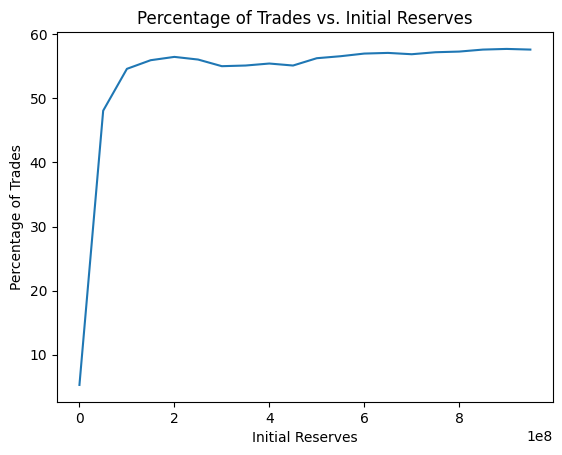

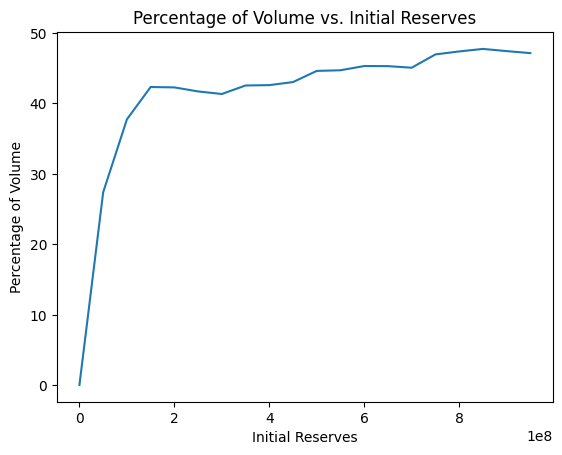

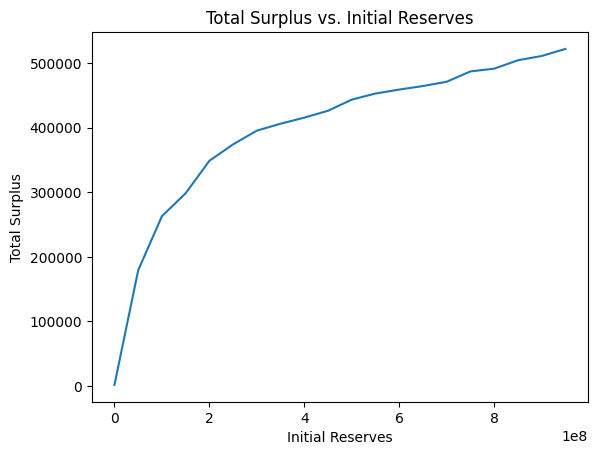

In [139]:
import matplotlib.pyplot as plt


token1 = "USDC"
token2 = "WETH"
fee_rate = 0.000 

# Study Starting reserves impact on key variables 

x = []
y1 = []
y2 = []
y3 = []


#range from 10mln to 1bn in 50mn increments for starting reserves. 
for token1_starting_reserves in range(100000, 1000100000, 50000000):
    x.append(token1_starting_reserves)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1.append(trades_executed_percentage)
    y2.append(executed_volume_percentage)
    y3.append(total_surplus)
    
    
df_results = pd.DataFrame({'starting reserves': x, '% of trades executed': y1, '% of volume executed': y2, 'total_surplus': y3})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df_results)


# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y1)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y2)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y3)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

plt.show()


#### Discussion: 

- Weird that % of trades rises and reaches a max then falls off. Thought it would be strictly increasing. 
- weird that surplus is linear wrt initial reserves


Note: 
Uni v2 USDC-WETH current reserves TVL : USD 86,620,798   
Uni v3 USDC-ETH current reserves TVL : 390,840,000 USD (Combining 0.3% pool + 0.05% pool )  

### b. Fee level 

## 4. DAI - USDT Study

### a. Initial Reserves

Holding Fee level = 0 %
Variable: Initial Reserves

(Study range: USD 100,000 - USD 1,000,000,000)

Note: Uni v2 USDC-WETH current reserves TVL : USD  (corresponds to initial reserves 43,310,399 in our study) Uni v3 USDC-WETH current reserves TVL : USD 230,510,000 (reserves DAI = USD 114,981,000


In [ ]:
import matplotlib.pyplot as plt


token1 = "DAI"
token2 = "USDT"
fee_rate = 0

# Study Starting reserves impact on key variables 

x = []
y1 = []
y2 = []
y3 = []


#range from 10mln to 1bn in 50mn increments for starting reserves. 
for token1_starting_reserves in range(100000, 1000100000, 50000000):
    x.append(token1_starting_reserves)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1.append(trades_executed_percentage)
    y2.append(executed_volume_percentage)
    y3.append(total_surplus)
    
    
df = pd.DataFrame({'starting reserves': x, '% of trades executed': y1, '% of volume executed': y2, 'total_surplus': y3})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df)


# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y1)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y2)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y3)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

plt.show()
